In [1]:
from desom.som_layer import SOMLayer
from desom.autoencoder import conv2d_autoencoder
from desom.datasets import load_data

import tensorflow as tf
from keras.models import Model, Sequential
from keras.metrics import Mean, MeanAbsoluteError

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import xarray as xr

%load_ext autoreload
%autoreload 2

In [2]:
(X, Y), (X_val, Y_val) = load_data('mnist', flatten=False)
X.shape

(70000, 28, 28, 1)

In [3]:
X_s = xr.open_dataarray('../../s_anom.nc').values[:, :, :, None]

In [17]:
map_size = (8, 8)
latent_dim = 10
input_shape = X_s.shape[1:]
autoencoder, encoder, decoder = conv2d_autoencoder(input_shape, latent_dim, [32, 64, 64], 3, 2)
autoencoder.compile('adam', 'mse')
save_dir = 'results/tmp'
epochs = 1
batch_size = 16
save_file = Path(f'{save_dir}/ae_weights-epoch{epochs}.h5')
if save_file.is_file():
    autoencoder.load_weights(save_file)
else:
    autoencoder.fit(X_s, X_s, epochs=epochs, batch_size=batch_size, verbose=1)
    # autoencoder.save_weights(save_file)
# som_layer = SOMLayer(map_size, name='som')(encoder.output)
# model = Model(
#     inputs=autoencoder.input, outputs=[autoencoder.output, som_layer]
# )
# model.compile(
#     loss={"decoder_0": "mse", "som": 'mse'},
#     loss_weights=[1, 0.],
#     optimizer='adam',
# )

2023-06-16 11:15:32.053544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1439/1439 [==============================] - 291s 201ms/step - loss: 31.9622


1/1 [==============================] - 0s 48ms/step


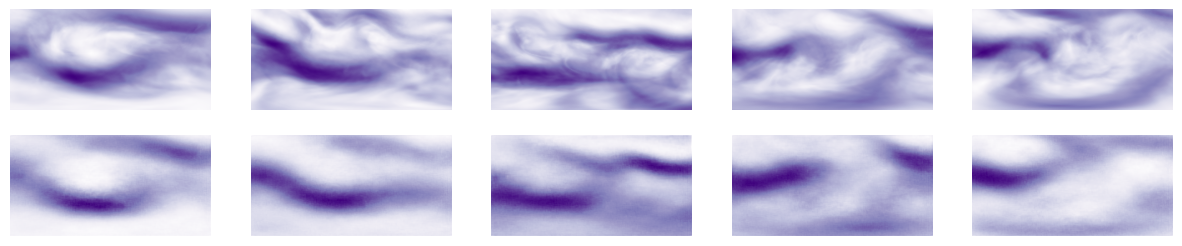

In [22]:
indices = np.random.randint(len(X_s), size=5)
theseX = X_s[indices]
theseXp = autoencoder.predict(theseX)
fig, axes = plt.subplots(2, 5, figsize=(15, 3))
for x, xp, axs in zip(theseX, theseXp, axes.T):
    axs[0].imshow(x, cmap='Purples')
    axs[1].imshow(xp, cmap='Purples')
    for ax in axs:
        ax.axis('off')

In [26]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense2 (Dense)              (None, 61504)             676544    
                                                                 
 reshape (Reshape)           (None, 31, 31, 64)        0         
                                                                 
 decoder_conv_2 (Conv2D)     (None, 31, 31, 64)        36928     
                                                                 
 decoder_upsample_2 (UpSamp  (None, 62, 62, 64)        0         
 ling2D)                                                         
                                                                 
 decoder_conv_1 (Conv2D)     (None, 62, 62, 64)        36928     
                                                           

1/1 [==============================] - 0s 44ms/step


ValueError: cannot reshape array of size 59536 into shape (121,241)

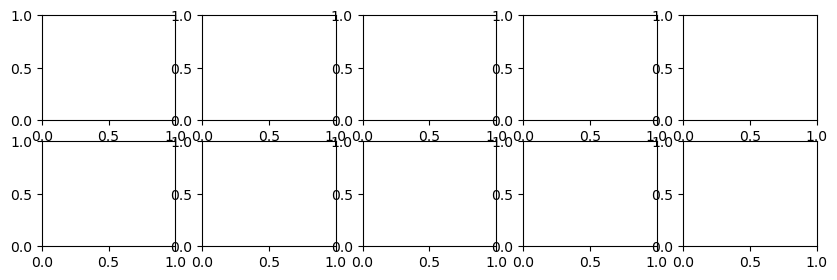

In [24]:
images = decoder.predict(np.eye(latent_dim)[:, :, None])
fig, axes = plt.subplots(2, 5, figsize=(10, 3))
for im, ax in zip(images, axes.flatten(order='F')):
    ax.imshow(im.reshape(X_s.shape[1:3]), cmap='gray')
    ax.axis('off')

In [25]:
im.shape

(244, 244, 1)

In [13]:
epochs = 5
batch_size = 256
for layer in model.layers[:-1]:
    layer.trainable = False
model.fit(X, [X, Y], epochs=epochs, batch_size=batch_size, verbose=1)

2/2 [==============================] - 0s 6ms/step


2023-06-14 18:20:02.758892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


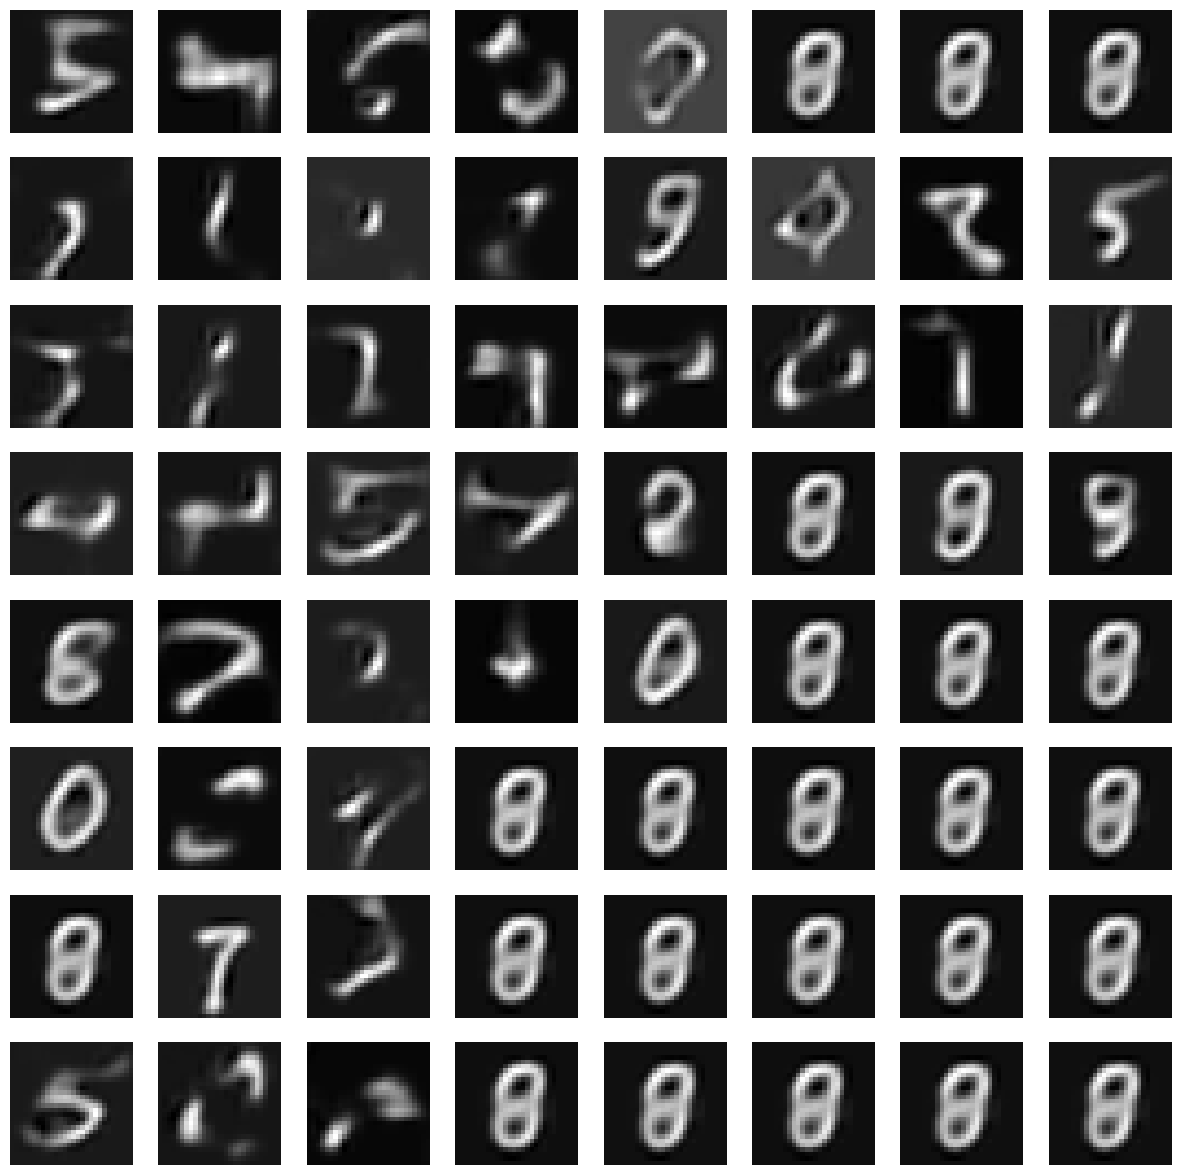

In [14]:
images = decoder.predict(model.get_layer(name='som').get_weights()[0][:, :, None])
fig, axes = plt.subplots(*map_size, figsize=(15, 15))
for im, ax in zip(images, axes.flatten(order='F')):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

In [ ]:
from keras.layers import Lambda
argmax_layer = Lambda(lambda x: tf.argmin(x, axis=1), name='y_pred')(som_layer)
classifier = Model(inputs=encoder.input, outputs=argmax_layer)
classifier.predict(X[0:100])

In [ ]:
from keras.layers import Input
def zeroloss(ypred, ytrue):
    return 0.
(X, Y), (X_val, Y_val) = load_data('mnist', flatten=True)
map_size = (8, 8)

x = Input(shape=(X.shape[1],), name='input')
som = SOMLayer(map_size, name='som')(x)
onlysom = Model(inputs=x, outputs=som)
onlysom.compile(optimizer='adam')
onlysom.fit(X, batch_size=256, epochs=5)

In [ ]:
images = onlysom.get_layer(name='som').get_weights()[0]
fig, axes = plt.subplots(*map_size, figsize=(15, 15))
for im, ax in zip(images, axes.flatten(order='F')):
    ax.imshow(im.reshape((28, 28)), cmap='gray')
    ax.axis('off')